In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora')

# Prepare data
data = dataset[0]

# Define a 2-layer GCN
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Initialize model, optimizer, and loss function
model = GCN(input_dim=dataset.num_node_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

original_loss = []

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        original_loss.append(loss.item())

print("Training complete!")


Epoch 0, Loss: 1.9568594694137573
Epoch 10, Loss: 0.7419667840003967
Epoch 20, Loss: 0.141326442360878
Epoch 30, Loss: 0.02769034169614315
Epoch 40, Loss: 0.0089414706453681
Epoch 50, Loss: 0.004606436472386122
Epoch 60, Loss: 0.0031311511993408203
Epoch 70, Loss: 0.002470282604917884
Epoch 80, Loss: 0.0020868275314569473
Epoch 90, Loss: 0.0018244627863168716
Training complete!


In [3]:
model.eval()

with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1) # get prediction
    
    # Calculate the accuracy on the test set
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / int(data.test_mask.sum())

# Print the test accuracy
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7780


## Explanation:
GCN aggregates features from a node’s neighbors using graph convolutions. This allows the network to learn representations based on both node features and graph structure.
The Cora dataset is used to classify nodes into one of 7 research topics.

In [14]:
import matplotlib.pyplot as plt

## Questions (1 point each):

#### 1. What would happen if we added more GCN layers (e.g., 3 layers instead of 2)? How would this affect over-smoothing?

My intuition is that adding more layers will improve the model performance. As GCNs use the structure of graphs to aggregate information from a node's neighbors, adding more layers to a GCN means doing more aggregation of these information, which would in turn cause the nodes to become more similar to their neighbors and may lead to over-smoothing.

Notes:
- Over-smoothing: interacting nodes would have quite similar representations; may occur b/c layers aggregate info from neighboring nodes

In [10]:
# Define a 3-layer GCN
class GCN_3_layer(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(GCN_3_layer, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        return torch.log_softmax(x, dim=1)

In [11]:
# Initialize model, optimizer, and loss function
model_3 = GCN_3_layer(input_dim=dataset.num_node_features, hidden_dim1=16, hidden_dim2=16, output_dim=dataset.num_classes)
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.01)
criterion_3 = nn.CrossEntropyLoss()

In [12]:
more_layers_loss = []

for epoch in range(100):
    model_3.train()
    optimizer_3.zero_grad()

    out = model_3(data)
    loss = criterion_3(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_3.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        more_layers_loss.append(loss.item())

print("Training complete for the 3-layer GCN!")

Epoch 0, Loss: 1.9482250213623047
Epoch 10, Loss: 0.8057654500007629
Epoch 20, Loss: 0.11420620232820511
Epoch 30, Loss: 0.011890009976923466
Epoch 40, Loss: 0.002345786662772298
Epoch 50, Loss: 0.0009437575936317444
Epoch 60, Loss: 0.0006107919034548104
Epoch 70, Loss: 0.00048000007518567145
Epoch 80, Loss: 0.00041353722917847335
Epoch 90, Loss: 0.0003713270998559892
Training complete for the 3-layer GCN!


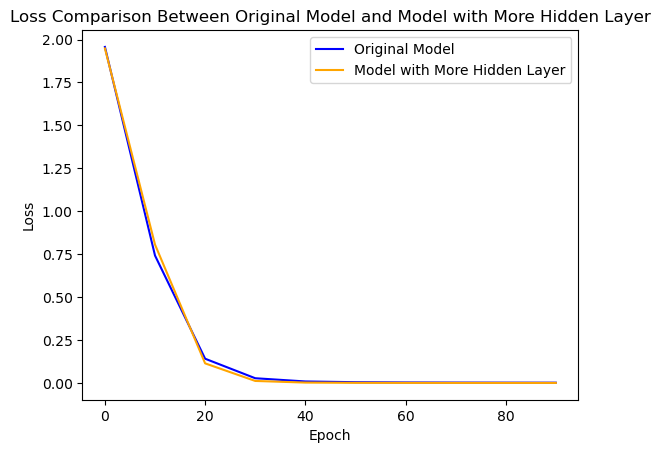

In [28]:
# compare the loss of models
epochs = range(0, 100, 10)

plt.plot(epochs, original_loss, label='Original Model', color='blue')
plt.plot(epochs, more_layers_loss, label='Model with More Hidden Layer', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison Between Original Model and Model with More Hidden Layer')
plt.legend()
plt.show()

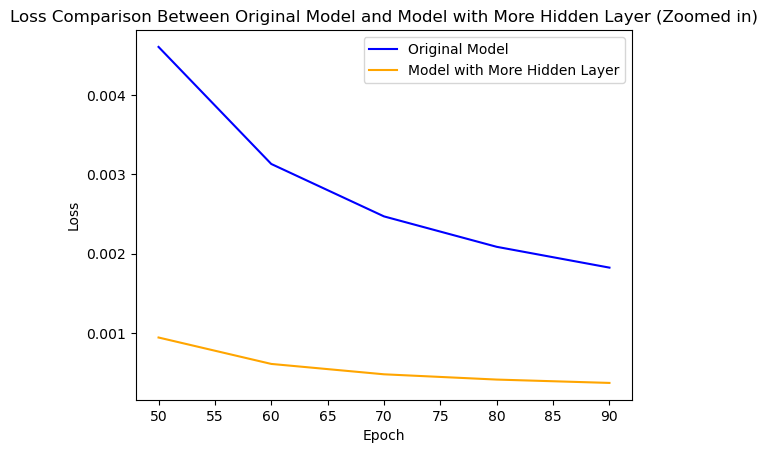

In [29]:
# compare the loss of model w/ 2 and 3 hidden layers
epochs = range(0, 100, 10)

plt.plot(epochs[5:], original_loss[5:], label='Original Model', color='blue')
plt.plot(epochs[5:], more_layers_loss[5:], label='Model with More Hidden Layer', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison Between Original Model and Model with More Hidden Layer (Zoomed in)')
plt.legend()
plt.show()

The GCN with more layers does show an improvement in the training losses, which aligns with my intuition. This trend is more obvious as we zoom in to the last 50 epochs of the two GCNs -- although both models demonstrate a continuous decline in loss, the 3-layer model consistently has a loss that is about 3 times lower than the 2-layer model. This different suggests that the 3-layer model has a higher capacity of learning the node features.

In [13]:
model_3.eval()

with torch.no_grad(): 
    out = model_3(data)
    pred = out.argmax(dim=1) # get prediction

    # Calculate accuracy on the test set
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / int(data.test_mask.sum())

print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7650


However, as we add this layer to the GCN, the test accuracy drops slightly. This suggest that adding this layer with the specified parameters to the GCN did not improve the model's performance on the test set. 

In my opinion, this drop may be due to the over-smoothing problem, as increasing the number of the GCN layers without regularization may cause the node embeddings to become too similar to each other. This problem may lead to the model being less capable of distinguishing between nodes in different classes. This may be improved by adding regularizations like dropout, or adjusting layer parameters like the activation function or the number of nodes.

#### 2. What would happen if we used a larger hidden dimension (e.g., 64 instead of 16)? How would this impact the model's capacity?

In [27]:
# input dim
dataset.num_node_features

1433

My intuition is that this may increase the model's capacity to learn the node features. Increasing the hidden dimension may allow the network to capture more complex and nuance relationships between nodes, especially when the dataset have a large number of features associated with each node (1433). It is also worth noting that the computational cost will likely increase.

In [39]:
model_large_hidden = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=dataset.num_classes)
optimizer_large_hidden = optim.Adam(model_large_hidden.parameters(), lr=0.01)
criterion_large_hidden = nn.CrossEntropyLoss()

In [40]:
large_hidden_loss = []

for epoch in range(100):
    model_large_hidden.train()
    optimizer_large_hidden.zero_grad()
    
    out = model_large_hidden(data)
    loss = criterion_large_hidden(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_large_hidden.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        large_hidden_loss.append(loss.item())

print("Training complete for GCN w/ larger hidden layer!")

Epoch 0, Loss: 1.9450736045837402
Epoch 10, Loss: 0.07536640763282776
Epoch 20, Loss: 0.0028543605003505945
Epoch 30, Loss: 0.0005019005038775504
Epoch 40, Loss: 0.00022480549523606896
Epoch 50, Loss: 0.00015547452494502068
Epoch 60, Loss: 0.00013093967572785914
Epoch 70, Loss: 0.00011907191947102547
Epoch 80, Loss: 0.00011164788156747818
Epoch 90, Loss: 0.00010605396528262645
Training complete for GCN w/ larger hidden layer!


In [46]:
model_large_hidden_128 = GCN(input_dim=dataset.num_node_features, hidden_dim=128, output_dim=dataset.num_classes)
optimizer_large_hidden_128 = optim.Adam(model_large_hidden_128.parameters(), lr=0.01)
criterion_large_hidden_128 = nn.CrossEntropyLoss()

In [47]:
large_hidden_loss_128 = []

for epoch in range(100):
    model_large_hidden_128.train()
    optimizer_large_hidden_128.zero_grad()
    
    out = model_large_hidden_128(data)
    loss = criterion_large_hidden_128(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_large_hidden_128.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        large_hidden_loss_128.append(loss.item())

print("Training complete for GCN w/ larger hidden layer (128 dimension)!")

Epoch 0, Loss: 1.9353827238082886
Epoch 10, Loss: 0.016506068408489227
Epoch 20, Loss: 0.000410404521971941
Epoch 30, Loss: 6.826817843830213e-05
Epoch 40, Loss: 2.9960503525217064e-05
Epoch 50, Loss: 2.1590740288957022e-05
Epoch 60, Loss: 1.861133932834491e-05
Epoch 70, Loss: 1.732842792989686e-05
Epoch 80, Loss: 1.6648225937387906e-05
Epoch 90, Loss: 1.6170652088476345e-05
Training complete for GCN w/ larger hidden layer (128 dimension)!


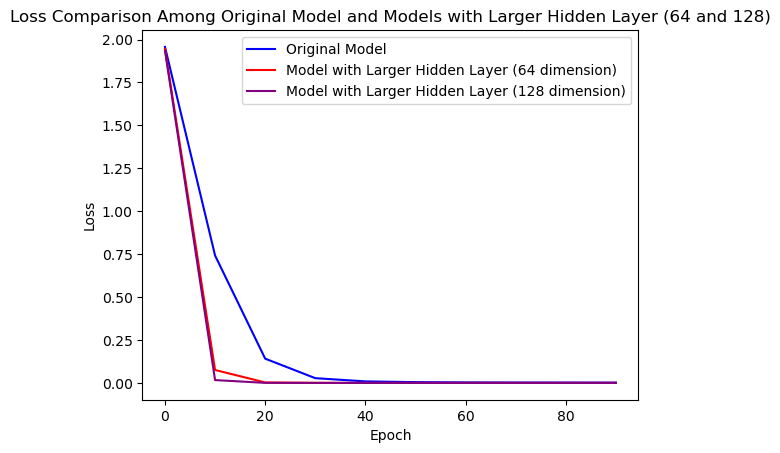

In [51]:
# compare the loss of models
epochs = range(0, 100, 10)

plt.plot(epochs, original_loss, label='Original Model', color='blue')
plt.plot(epochs, large_hidden_loss, label='Model with Larger Hidden Layer (64 dimension)', color='red')
plt.plot(epochs, large_hidden_loss_128, label='Model with Larger Hidden Layer (128 dimension)', color='purple')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison Among Original Model and Models with Larger Hidden Layer (64 and 128)')
plt.legend()
plt.show()

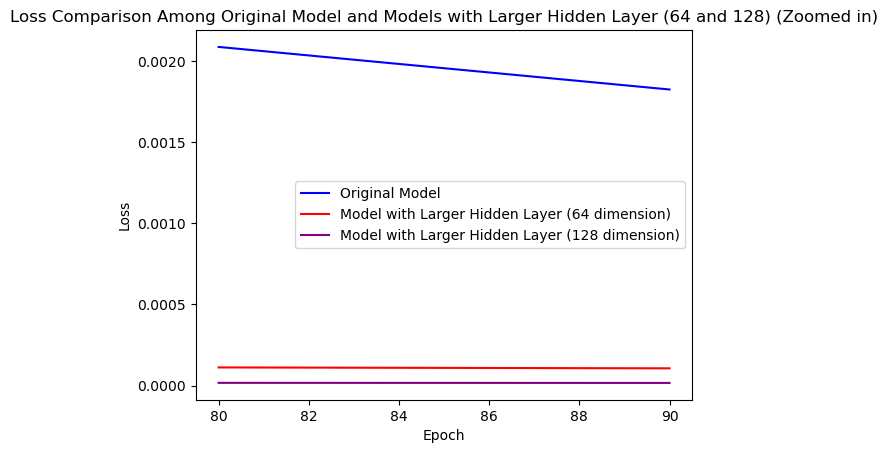

In [54]:
# compare the loss of models
epochs = range(0, 100, 10)

plt.plot(epochs[8:], original_loss[8:], label='Original Model', color='blue')
plt.plot(epochs[8:], large_hidden_loss[8:], label='Model with Larger Hidden Layer (64 dimension)', color='red')
plt.plot(epochs[8:], large_hidden_loss_128[8:], label='Model with Larger Hidden Layer (128 dimension)', color='purple')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison Among Original Model and Models with Larger Hidden Layer (64 and 128) (Zoomed in)')
plt.legend()
plt.show()

The models with larger hidden layers shows a faster initial drop in loss during early epochs, suggesting that they learn faster initially compared to the original model. This suggests that adding more hidden dimensions allows the models to have a larger capacity to capture the complex relationships in the data. However, there doesn't seem to be a large improvement when we increase the number of hidden dimensions from 64 to 128 as from 16 to 64, which may indicate diminishing returns.  

In [56]:
model_large_hidden.eval()
with torch.no_grad():
    out = model_large_hidden(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / int(data.test_mask.sum())
    
print(f'Test Accuracy with larger hidden dimension (64): {accuracy:.4f}')

Test Accuracy with larger hidden dimension (64): 0.7760


In [55]:
model_large_hidden_128.eval()
with torch.no_grad():
    out = model_large_hidden_128(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / int(data.test_mask.sum())
    
print(f'Test Accuracy with larger hidden dimension (128): {accuracy:.4f}')

Test Accuracy with larger hidden dimension (128): 0.7870


In [57]:
(0.7870-0.7760)/0.7760

0.014175257731958775

The test accuracies of models with larger hidden dimensions show improvement over both the 2-layer GCN with 16 hidden units (Test Accuracy: 0.7780) and the 3-layer GCN with 16 hidden units (Test Accuracy: 0.7650). This indicates that by increasing the number of hidden dimensions, the models gained **more capacity** to learn more complexed representations of the features, which allows the model to capture more details in the data. Although there doesn't seem to be a big improvement in training loss when we increase the number of hidden dimensions from 64 to 128, the test accuracy shows a 1.42% increase when this change happens.

In addition, increasing the hidden dimension in this particular case does not worsen the model performance by over-smoothing or overfitting. However, there is an associated increase in computational cost (shown in longer training time) as there are increased number of parameters.

#### 3. What would happen if we replaced ReLU activation with a sigmoid function? Would the performance change?

My intuition is that the performance may hurt because the sigmoid function have the vanishing gradient problem -- it forces the values into a small range, causing the gradients to shrink exponentially during propagation. Also, using sigmoid function may increase the computational cost.

In [33]:
class GCN_sigmoid(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN_sigmoid, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.sigmoid(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

In [43]:
model_sigmoid = GCN_sigmoid(input_dim=dataset.num_node_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer_sigmoid = optim.Adam(model_sigmoid.parameters(), lr=0.01)
criterion_sigmoid = nn.CrossEntropyLoss()

In [44]:
sigmoid_loss = []

for epoch in range(100):
    model_sigmoid.train()
    optimizer_sigmoid.zero_grad()
    
    out = model_sigmoid(data)
    loss = criterion_sigmoid(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_sigmoid.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        sigmoid_loss.append(loss.item())
        
print("Training complete for GCN w/ sigmoid activation!")

Epoch 0, Loss: 2.111198663711548
Epoch 10, Loss: 1.5377616882324219
Epoch 20, Loss: 1.1100229024887085
Epoch 30, Loss: 0.7555329203605652
Epoch 40, Loss: 0.48995867371559143
Epoch 50, Loss: 0.3145807683467865
Epoch 60, Loss: 0.2092157006263733
Epoch 70, Loss: 0.1474955677986145
Epoch 80, Loss: 0.11035003513097763
Epoch 90, Loss: 0.08673152327537537
Training complete for GCN w/ sigmoid activation!


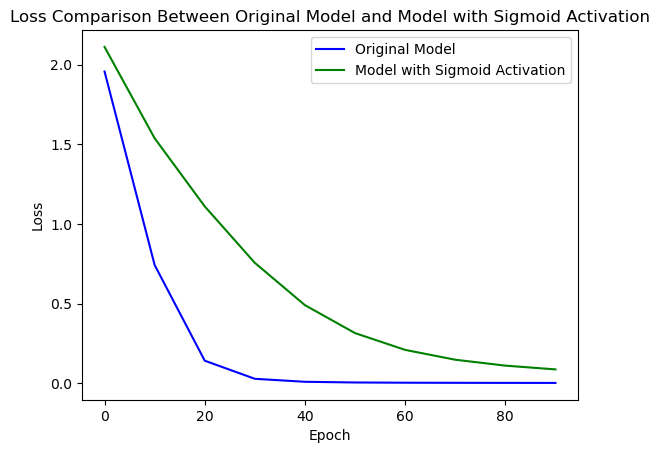

In [45]:
# compare the loss of models
epochs = range(0, 100, 10)

plt.plot(epochs, original_loss, label='Original Model', color='blue')
plt.plot(epochs, sigmoid_loss, label='Model with Sigmoid Activation', color='green')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison Between Original Model and Model with Sigmoid Activation')
plt.legend()
plt.show()

The model with sigmoid function shows a slower convergence with sigmoid, likely due to the vanishing gradient problem. This model also have a higher final loss compared to the original model. This suggests that it may not be able to fit the training data as effectively as ReLU.

In [36]:
model_sigmoid.eval()
with torch.no_grad():
    out = model_sigmoid(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / int(data.test_mask.sum())
    
print(f'Test Accuracy with sigmoid activation: {accuracy:.4f}')

Test Accuracy with sigmoid activation: 0.7740


The test accuracy with sigmoid activation function is slightly lower than with ReLU. This may be attributed to the vanishing gradient problem, which slows down the learning process and lead to slight decrease in model accuracy. On the other hand, ReLu allows for more sparsity and sets some neurons to output zero, which helps prevent the vanishing gradient problem. 

Moreover, I noticed that the training time of the model with sigmoid activation is longer than the one with ReLU activation. This could be attributed to the lower computational complexity of ReLU than sigmoid.

#### 4. What would happen if we trained on only 10% of the nodes and tested on the remaining 90%? How would the performance be affected?

My intuition is that the performance will worsen if we train on only 10% of the nodes. Details and variations of the node features may be lost if we reduce the training set size.

In [67]:
train_ratio = 0.1
num_train_nodes = int(train_ratio * data.num_nodes)

In [68]:
# Randomly shuffle the node indices
perm = torch.randperm(data.num_nodes)

In [69]:
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[perm[:num_train_nodes]] = True
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask[perm[num_train_nodes:]] = True

In [70]:
data.train_mask = train_mask
data.test_mask = test_mask

In [71]:
model_10_pct = GCN(input_dim=dataset.num_node_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer_10_pct = optim.Adam(model_10_pct.parameters(), lr=0.01)
criterion_10_pct = nn.CrossEntropyLoss()

In [72]:
ten_pct_loss = []

for epoch in range(100):
    model_10_pct.train()
    optimizer_10_pct.zero_grad()
    
    out = model_10_pct(data)
    loss = criterion_10_pct(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_10_pct.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        ten_pct_loss.append(loss.item())
        
print("Training complete for GCN w/ 10% training nodes!")

Epoch 0, Loss: 1.9589147567749023
Epoch 10, Loss: 0.8182008266448975
Epoch 20, Loss: 0.28515952825546265
Epoch 30, Loss: 0.09344135224819183
Epoch 40, Loss: 0.03368031233549118
Epoch 50, Loss: 0.015375778079032898
Epoch 60, Loss: 0.009139114059507847
Epoch 70, Loss: 0.006462481338530779
Epoch 80, Loss: 0.005033440887928009
Epoch 90, Loss: 0.004130547400563955
Training complete for GCN w/ 10% training nodes!


In [64]:
model_10_pct.eval()
with torch.no_grad():
    out = model_10_pct(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / int(data.test_mask.sum())
    
print(f'Test Accuracy with 10% training nodes: {accuracy:.4f}')

Test Accuracy with 10% training nodes: 0.8392


The test accuracy of the model trained on 10% of the nodes and test on the remaining 90% is higher than any other models constructed before, which contradicts my intuition. In my opinion, this could be due to several factors:

- The model may generalize better when trained on fewer nodes, because it is less likely to overfit on the training set.
- The graph structure of the dataset may be well-connected and informative enough that even a small number of training nodes is enough for the model to generalize well for the rest of the nodes.  

These hypotheses can be further validated through permutation testing, where he nodes are shuffled multiple times and different 10% nodes are used to train the model every time.

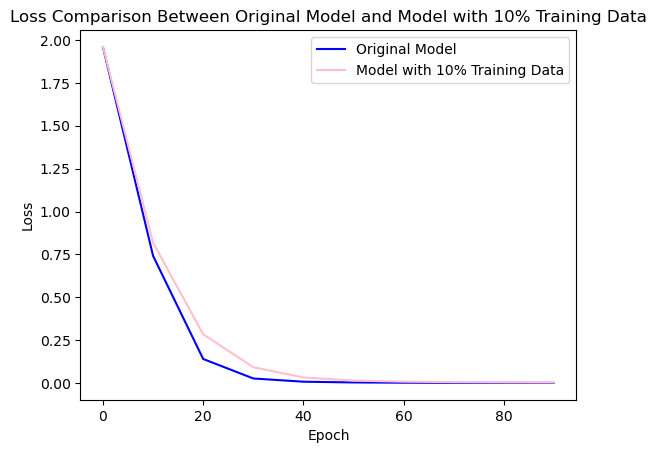

In [73]:
# compare the loss of models
epochs = range(0, 100, 10)

plt.plot(epochs, original_loss, label='Original Model', color='blue')
plt.plot(epochs, ten_pct_loss, label='Model with 10% Training Data', color='pink')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison Between Original Model and Model with 10% Training Data')
plt.legend()
plt.show()

The loss comparison show that the model trained on 10% of the data has similar losses as the original model in almost every epoch, suggesting that the model is able to capture the important patterns even with limited training nodes. This supports the hypothesis that the graph structure may be informative enough for a model to learn the important features even with a small portion of the nodes.

#### 5. What would happen if we used a different optimizer (e.g., RMSprop) instead of Adam? Would it affect the convergence speed?

According to [information online](https://www.geeksforgeeks.org/adam-optimizer/), "Intuitively, Adam is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm." Therefore, my guess is that RMSprop doesn't work as well as Adam.

In [74]:
data.train_mask = dataset[0].train_mask
data.test_mask = dataset[0].test_mask

In [78]:
model_rmsprop = GCN(input_dim=dataset.num_node_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=0.01)
criterion_rmsprop = nn.CrossEntropyLoss()

In [79]:
rmsp_loss = []

for epoch in range(100):
    model_rmsprop.train()
    optimizer_rmsprop.zero_grad()
    
    out = model_rmsprop(data)
    loss = criterion_rmsprop(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_rmsprop.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        rmsp_loss.append(loss.item())
        
print("Training complete for GCN w/ RMSprop optimizer!")

Epoch 0, Loss: 1.9458510875701904
Epoch 10, Loss: 0.03764250501990318
Epoch 20, Loss: 0.014949948526918888
Epoch 30, Loss: 0.008617302402853966
Epoch 40, Loss: 0.005815676413476467
Epoch 50, Loss: 0.004274457693099976
Epoch 60, Loss: 0.003312336280941963
Epoch 70, Loss: 0.0026600148994475603
Epoch 80, Loss: 0.002192542888224125
Epoch 90, Loss: 0.001843579695560038
Training complete for GCN w/ RMSprop optimizer!


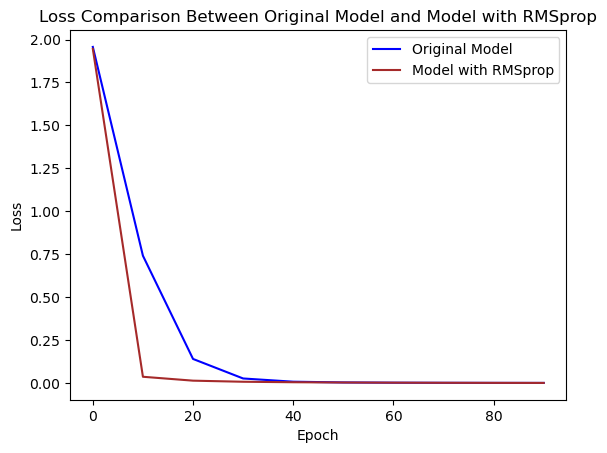

In [80]:
# compare the loss of models
epochs = range(0, 100, 10)

plt.plot(epochs, original_loss, label='Original Model', color='blue')
plt.plot(epochs, rmsp_loss, label='Model with RMSprop', color='brown')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison Between Original Model and Model with RMSprop')
plt.legend()
plt.show()

In [77]:
model_rmsprop.eval()
with torch.no_grad():
    out = model_rmsprop(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / int(data.test_mask.sum())

print(f'Test Accuracy with RMSprop optimizer: {accuracy:.4f}')

Test Accuracy with RMSprop optimizer: 0.7970


The model with RMSprop seems to improve in test accuracy. It also has a faster-converging training loss in the first 30 epochs, possibly due to its ability to adjust learning rates based on recent gradients. This is different from my guess. Nevertheless, both models have a similar final loss, suggesting this choice of optimizer doesn't significantly impact the final model performance in this case.

### Extra credit: 
#### 1. What would happen if we used edge weights (non-binary) in the adjacency matrix? How would it affect message passing?

When we use binary adjacency matrices in GCNs, the information passed between nodes is binary, meaning there is either a connection (1) or no connection (0). On the other hand, if we use edge weights (non-binary) in the adjacency matrix, the information aggregated by each node from its neighbors will be weighted by the strength of the connection between nodes. This means that during the message passing process, nodes connected by stronger edges would contribute more to the final representation of a node. 

By using the edge weight in adjacency matrix, the model may capture more details about the relationships between nodes and better learn the features, leading to richer node embeddings and potentially improving the model performance. This may also introduce more complexity in the model learning process, which can be suitable for complex network or graph structures but also lead to higher computational cost.

Using edge weights will change the way different neighbors contribute to the update of one node, as they use edge weights to weigh the contributions instead of using binary ones. My guess is that making this change will enable stronger representation of relationships and allow the model to capture the relationships better by including the weights. 

In [35]:
# dir(data)

In [81]:
class GCN_with_weights(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN_with_weights, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return torch.log_softmax(x, dim=1)

In [82]:
model_weighted = GCN_with_weights(input_dim=dataset.num_node_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer_weighted = optim.Adam(model_weighted.parameters(), lr=0.01)
criterion_weighted = nn.CrossEntropyLoss()

In [83]:
edge_weight_loss = []

for epoch in range(100):
    model_weighted.train()
    optimizer_weighted.zero_grad()
    
    out = model_weighted(data)
    loss = criterion_weighted(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_weighted.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        edge_weight_loss.append(loss.item())
        
print("Training complete for GCN w/ edge weights!")

Epoch 0, Loss: 1.9431604146957397
Epoch 10, Loss: 0.5414925813674927
Epoch 20, Loss: 0.08873099833726883
Epoch 30, Loss: 0.018854090943932533
Epoch 40, Loss: 0.007091802079230547
Epoch 50, Loss: 0.004034359939396381
Epoch 60, Loss: 0.002912738360464573
Epoch 70, Loss: 0.002367160050198436
Epoch 80, Loss: 0.0020359226036816835
Epoch 90, Loss: 0.0017992276698350906
Training complete for GCN w/ edge weights!


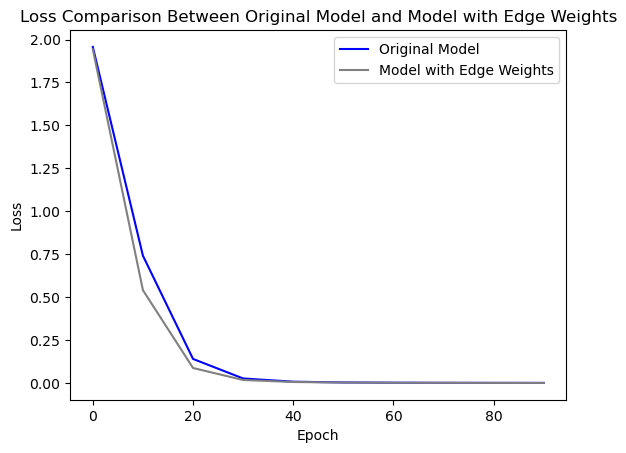

In [84]:
# compare the loss of models
epochs = range(0, 100, 10)

plt.plot(epochs, original_loss, label='Original Model', color='blue')
plt.plot(epochs, edge_weight_loss, label='Model with Edge Weights', color='gray')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison Between Original Model and Model with Edge Weights')
plt.legend()
plt.show()

In [85]:
model_weighted.eval()
with torch.no_grad():
    out = model_weighted(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / int(data.test_mask.sum())

print(f'Test Accuracy with edge weights: {accuracy:.4f}')

Test Accuracy with edge weights: 0.7830


Both the loss comparison plot and the test accuracies show that the models using non-binary weights and binary weights don't have a huge difference in performance. This suggest that the additional information from the edge weights might not be highly influential to improve model performance. My guess is that the relationships in this particular dataset are relatively uniform. 

#### 2. What would happen if we removed the log-softmax function in the output layer? Would the loss function still work correctly?

My intuition is that the loss function will not work correctly, as the form of output is changed.

In [2]:
class GCN_no_logsoftmax(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN_no_logsoftmax, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index) 
        return x 

In [3]:
model_no_logsoftmax = GCN_no_logsoftmax(input_dim=dataset.num_node_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer_no_logsoftmax = optim.Adam(model_no_logsoftmax.parameters(), lr=0.01)
criterion_no_logsoftmax = nn.CrossEntropyLoss()  # This already applies softmax internally

In [7]:
for epoch in range(100):
    model_no_logsoftmax.train()
    optimizer_no_logsoftmax.zero_grad()
    
    out = model_no_logsoftmax(data)
    
    loss = criterion_no_logsoftmax(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_no_logsoftmax.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

print("Training complete for GCN w/o log softmax!")

Epoch 0, Loss: 1.953733205795288
Epoch 10, Loss: 0.5637298226356506
Epoch 20, Loss: 0.08987681567668915
Epoch 30, Loss: 0.01918867975473404
Epoch 40, Loss: 0.007057531271129847
Epoch 50, Loss: 0.0039271279238164425
Epoch 60, Loss: 0.0028138982597738504
Epoch 70, Loss: 0.002280070213600993
Epoch 80, Loss: 0.0019572952296584845
Epoch 90, Loss: 0.0017287489026784897
Training complete for GCN w/o log softmax!


In [10]:
import torch.nn.functional as F

In [12]:
model_no_logsoftmax.eval()
with torch.no_grad():
    out = model_no_logsoftmax(data)

# Print the output for a few nodes
print("Output (first 5 training nodes):")
print(out[data.train_mask][:5])

# Apply softmax to the output to convert them into probabilities
probabilities = F.softmax(out, dim=1)

# Print the probabilities for the same nodes
print("\nProbabilities (after applying softmax, first 5 training nodes):")
print(probabilities[data.train_mask][:5])

# Check the sum of probabilities
print("\nSum of probabilities:")
print(probabilities[data.train_mask][:5].sum(dim=1))

Output (first 5 training nodes):
tensor([[-3.2499, -1.0346, -4.3134,  6.3326, -2.1912, -1.8376, -5.6061],
        [-4.8734, -3.7940,  0.3320, -3.4253, 11.6896, -4.2241, -4.5810],
        [-6.3840, -3.6482, -0.7484,  0.0278,  9.3596, -3.5577, -5.5921],
        [ 7.7711, -3.0735, -2.5449, -4.2608, -3.7189, -3.7195, -0.4565],
        [-3.7300, -1.3807, -2.6438,  5.7616, -2.0244, -1.7527, -6.1350]])

Probabilities (after applying softmax, first 5 training nodes):
tensor([[6.8841e-05, 6.3083e-04, 2.3765e-05, 9.9879e-01, 1.9843e-04, 2.8262e-04,
         6.5244e-06],
        [6.4088e-08, 1.8861e-07, 1.1680e-05, 2.7269e-07, 9.9999e-01, 1.2268e-07,
         8.5853e-08],
        [1.4540e-07, 2.2425e-06, 4.0750e-05, 8.8557e-05, 9.9987e-01, 2.4549e-06,
         3.2101e-07],
        [9.9965e-01, 1.9503e-05, 3.3089e-05, 5.9493e-06, 1.0228e-05, 1.0223e-05,
         2.6709e-04],
        [7.5328e-05, 7.8930e-04, 2.2320e-04, 9.9795e-01, 4.1466e-04, 5.4411e-04,
         6.7994e-06]])

Sum of probabilitie

If the log-softmax function is removed from the output layer of the model, the model will output logits, which is the raw scores each class. When we apply softmax manually on these numbers and convert them into probabilities, they sum up to one for each node. 

In [13]:
train_nodes = data.train_mask.nonzero(as_tuple=True)[0][:5]

# Manually calculate the loss w/ softmax and NLL
log_probs = F.log_softmax(out[train_nodes], dim=1)  # Log-softmax
nll_loss_manual = -log_probs[range(5), data.y[train_nodes]].mean()  # NLL

print(f"Manually calculated NLL loss: {nll_loss_manual.item()}")

# Compare with nn.CrossEntropyLoss
nll_loss_crossentropy = criterion_no_logsoftmax(out[train_nodes], data.y[train_nodes])

print(f"Loss from nn.CrossEntropyLoss: {nll_loss_crossentropy.item()}")

Manually calculated NLL loss: 0.0007521277293562889
Loss from nn.CrossEntropyLoss: 0.0007521277293562889


After manually computing the negative log-likelihood loss from the output logits and comparing them with the output of CrossEntropyLoss, they are the same. This is different from my intuition.

After searching online, I find that `nn.CrossEntropyLoss` will internally apply the softmax function to convert the logits into probabilities before computing the loss. Therefore, the loss function will still run correctly even if we remove softmax from the model output layer. 

## No points, just for you to think about:

#### 1. What would happen if we applied dropout to the node features during training? How would it affect the model’s generalization?

My intuition is that applying dropout will prevent overfitting and allow the model to generalize better. However, too much dropout may cause the model to underfit. Thus, if we pick an appropriate dropout rate, we should expect an increase in test accuracy. 

#### 2. What would happen if we used mean-pooling instead of summing the messages in the GCN layers?


Using mean-pooling may change the way of information aggregation in the GCN layers. This can lead to a more balanced influence of nodes on their neighbors by preventing nodes with too many neighbors having a larger influence on its neighbors with the aggregated message. This change's influence on model performance is hard to determine and may depend on the graph structure. If the numbers of neighbors each node have are relatively uniform in the graph, this change may not have too much impact.

#### 3. What would happen if we pre-trained the node features using a different algorithm, like Node2Vec, before feeding them into the GCN?

Node2Vec is a random walk algorithm that explores the neighborhood of nodes and generates numerical representations of nodes in the graph containing both local and global structural information. Therefore, if we pretrain the node features with Node2Vec, each node's initial embedding already contains information about its position and neighbors, which can potentially improve GCN's initial performance. Thus, GCN may have a faster convergence and a improved performance.